In [93]:
import pandas as pd
import numpy as np
from ggplot import *

import numpy as np
import matplotlib.pyplot as plt


%matplotlib inline

In [85]:
df_orig = pd.read_csv('./data/combined_wh_pay.csv')
df_orig['Name'] = df_orig['Name'].str.strip()



### Check for duplicate cleaned names

In [86]:
df = df_orig
df.loc[ df.Gender =='?', 'Gender'] = np.nan
df.loc[ df.Salary ==0, 'Gender'] = np.nan
df = df.dropna()


#### The duplicates in cleaned_names is because of non-equivalent entries not different people

In [108]:
import itertools

cleaned = df.groupby(df['Cleaned_Name'])
actual = df.groupby(df['Name'])
print len(actual), len(cleaned)

for group in cleaned:
    names = set(group[1].Name)
    if len(names) > 1:
        print df[ df['Cleaned_Name'] == group[0]].sort('Year')
        
#michael gottlieb set(['Gottlieb, Michael J.', 'Gottlieb, Michael D.'])
#nancy-ann deparle set(['DeParle, Nancy-Ann E.', 'DeParle, Nancy-Ann M.'])
#nicholas mcquaid set(['McQuaid, Nicholas L.', 'McQuaid, Nicholas R.'])
#stephanie cutter set(['Cutter, Stephanie A.', 'Cutter, Stephanie', 'Cutter, Stephanie N.'])

1414 1385
     Unnamed: 0              Name    Status  Salary  Pay_Basis  \
480         480  Witt, Abigail B.  Employee   40000  Per Annum   
947         947     Witt, Abigail  Employee   45000  Per Annum   

                                                 Title  Cleaned_Name  Year  \
480  SPECIAL ASSISTANT TO THE CHIEF OF STAFF OF THE...  abigail witt  2009   
947  SPECIAL ASSISTANT TO THE CHIEF OF STAFF OF THE...  abigail witt  2010   

     Gender  
480  female  
947  female  
      Unnamed: 0                  Name    Status  Salary  Pay_Basis  \
933          933     Wang-Levine, Adam  Employee   55080  Per Annum   
1389        1389     Wang-Levine, Adam  Employee   55080  Per Annum   
2766        2766  Wang-Levine, Adam Y.  Employee   55080  Per Annum   
1847        1847  Wang-Levine, Adam Y.  Employee   55080  Per Annum   

               Title      Cleaned_Name  Year Gender  
933   POLICY ADVISOR  adam wang-levine  2010   male  
1389  POLICY ADVISOR  adam wang-levine  2011   mal

In [110]:
df[ df['Cleaned_Name'] == 'stephanie cutter']

,Unnamed: 0,Name,Status,Salary,Pay_Basis,Title,Cleaned_Name,Year,Gender
95,95,"Cutter, Stephanie A.",Employee,153200,Per Annum,ADVISOR TO THE PRESIDENT,stephanie cutter,2009,female
575,575,"Cutter, Stephanie",Employee,172200,Per Annum,ASSISTANT TO THE PRESIDENT FOR SPECIAL PROJECTS,stephanie cutter,2010,female
1036,1036,"Cutter, Stephanie N.",Employee,172200,Per Annum,ASSISTANT TO THE PRESIDENT AND DEPUTY SENIOR A...,stephanie cutter,2011,female


### Functions

In [142]:
def check_alphnum(char):
    char = ord(char)
    if (char >= 48) & (char <= 57):
        return True
    elif (char >= 65) & (char <= 90):
        return True
    elif (char >= 97) & (char <= 122):
        return True
    elif char == 32:
        return True
    else:
        return False
    
def check_word(word):
    return "".join([char for char in word if check_alphnum(char)]) 

In [143]:
# need to get rid of all the repeats
# repeats are when cleaned_name == cleaned_name and Title == Title

df = df_orig.drop_duplicates(subset=['Title','Cleaned_Name'])
df_all = df

### Logistic Regression

In [144]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

stop = stopwords.words('english')
df = df[ df['Salary']<80000]
titles = df['Title'].str.split().apply(lambda x: [item.lower() for item in x])
titles = titles.apply(lambda sentence: [check_word(word) for word in sentence])
df['Cleaned_Title'] = titles.apply(lambda x: " ".join(x))
vectorizer = CountVectorizer(analyzer = 'word',
                            ngram_range = (1,10),
                            max_features = 5000)
Xts = vectorizer.fit_transform(df['Cleaned_Title'])

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


What words are predictive of if the job is M/F?

In [145]:
from sklearn.linear_model import LogisticRegression
from scipy import sparse
from sklearn import metrics, cross_validation

sex = df['Gender'].apply(lambda x: 0 if x=='male' else 1).astype(int)
model = LogisticRegression()

SEED = 4
N = 10
result_list = []
for i in range(N):
    X_train, X_cv, y_train, y_cv = cross_validation.train_test_split(Xts, sex, test_size=0.2,\
        random_state = i*SEED)
    model.fit(X_train, y_train)
#    preds_proba = model.predict_proba(Xts)
    preds = model.predict(X_cv)    
    result = [(x ^ y) for x, y in zip(preds, y_cv)]
    result_list.append(1-sum(result)/float(len(result)))
print sum(result_list)/float(len(result_list))
df.Gender.value_counts()[0] / float(len(df))


#print metrics.f1_score(sex, preds)

0.560569105691


0.54241435562805873

In [146]:
a = sorted(zip(vectorizer.get_feature_names(), model.coef_[0]),key=lambda x:x[1], reverse=True)

Female Jobs

In [147]:
a[:10]

[(u'research', 1.0024276650953252),
 (u'stenographer', 0.79813581276214718),
 (u'special assistant to the director of', 0.76923922304845782),
 (u'senior presidential', 0.59109723729051478),
 (u'senior presidential speechwriter', 0.59109723729051478),
 (u'deputy', 0.57203486242299439),
 (u'press lead', 0.57001364250254993),
 (u'assistant to the director of', 0.54961505683097367),
 (u'research associate', 0.54345660865106149),
 (u'events', 0.53646699015076782)]

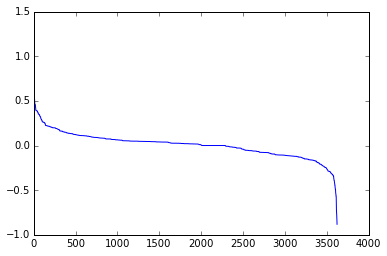

In [148]:
b = [x[1] for x in a]

plt.plot(b)

In [149]:
for i in range(40):
    mask = df['Cleaned_Title'].str.contains(a[i][0])
    newdf = df[mask].groupby('Cleaned_Name')
    num = len(newdf)
    if num > 10:
        MF = newdf.apply(lambda x: (x.Gender.values[0]))
        try:
            F, M = MF.value_counts()[:2]
            print F, M, a[i]
        except:
            F = MF.value_counts()[0]
            print F, a[i]
    
lena = len(a)-1
print '-'*10, 'men'

for i in range(lena, lena-40, -1):
    mask = df['Cleaned_Title'].str.contains(a[i][0])
    newdf = df[mask].groupby('Cleaned_Name')
    num = len(newdf)
    if num > 10:
        MF = newdf.apply(lambda x: (x.Gender.values[0]))
        try:
            M, F = MF.value_counts()[:2]
            print F, M, a[i]
        except:
            M = MF.value_counts()[0]
            print M, a[i]

18 8 (u'research', 1.0024276650953252)
13 1 (u'special assistant to the director of', 0.76923922304845782)
75 48 (u'deputy', 0.57203486242299439)
8 3 (u'press lead', 0.57001364250254993)
18 3 (u'assistant to the director of', 0.54961505683097367)
18 4 (u'the director of', 0.48293526365450506)
18 4 (u'to the director of', 0.48293526365450506)
32 9 (u'executive assistant', 0.45645573636451237)
9 3 (u'assistant for', 0.42898768218590233)
18 8 (u'deputy associate director', 0.42571075509505274)
8 7 (u'correspondence analyst', 0.39995439712282377)
10 6 (u'travel', 0.39370069081347087)
---------- men
17 24 (u'presidential', -0.88238590428867625)
10 12 (u'counsel', -0.84837620329647834)
5 6 (u'deputy associate director of', -0.75505926385855193)
8 9 (u'press assistant', -0.65862455324099967)
17 22 (u'advance', -0.57329161916810112)
5 8 (u'speechwriter', -0.49845880449425689)
9 12 (u'media', -0.47403848271742194)
5 6 (u'vetter', -0.47012208128043048)
5 9 (u'advance lead', -0.4684673436538031)


In [96]:
grouped = df[ df['Cleaned_Title'].str.contains("stenography")].groupby('Cleaned_Name')
MF = grouped.apply(lambda x: (x.Gender.values[0]))
MF.value_counts()

female    3
male      1
dtype: int64

In [337]:
df[ df['Cleaned_Title'].str.contains("executive assistant")]

,Unnamed: 0,Name,Status,Salary,Pay_Basis,Title,Cleaned_Name,Year,Gender,Cleaned_Title
2,2,"Adams, Ian H.",Employee,36000,Per Annum,EXECUTIVE ASSISTANT TO THE DIRECTOR OF SCHEDUL...,ian adams,2009,male,executive assistant to the director of schedul...
8,8,"Anderson, Amanda D.",Employee,55000,Per Annum,EXECUTIVE ASSISTANT TO THE CHIEF OF STAFF,amanda anderson,2009,female,executive assistant to the chief of staff
38,38,"Boswell, Joseph J.",Employee,40000,Per Annum,EXECUTIVE ASSISTANT TO THE CHIEF OF STAFF TO T...,joseph boswell,2009,male,executive assistant to the chief of staff to t...
40,40,"Branch, Katherine Y.",Employee,60000,Per Annum,EXECUTIVE ASSISTANT TO THE SENIOR ADVISOR,katherine branch,2009,female,executive assistant to the senior advisor
43,43,"Brewer, Anne P.",Employee,36000,Per Annum,EXECUTIVE ASSISTANT TO THE DIRECTOR OF PUBLIC ...,anne brewer,2009,female,executive assistant to the director of public ...
45,45,"Brown, Amanda K.",Employee,45000,Per Annum,EXECUTIVE ASSISTANT,amanda brown,2009,female,executive assistant
58,58,"Campoverdi, Alejandra M.",Employee,55000,Per Annum,EXECUTIVE ASSISTANT TO THE DEPUTY CHIEF OF STA...,alejandra campoverdi,2009,female,executive assistant to the deputy chief of sta...
63,63,"Carter, Rhonda M.",Employee,50000,Per Annum,EXECUTIVE ASSISTANT,rhonda carter,2009,female,executive assistant
122,122,"Dunn, Lauren P.",Employee,45000,Per Annum,EXECUTIVE ASSISTANT,lauren dunn,2009,female,executive assistant
179,179,"Hable, Abigail K.",Employee,40000,Per Annum,EXECUTIVE ASSISTANT,abigail hable,2009,female,executive assistant


Male Jobs

In [132]:
a[-20:]

[(u'associate director of scheduling', -0.59784654881251231),
 (u'technology', -0.60154304977054252),
 (u'clerk', -0.60341310736728337),
 (u'executive clerk', -0.60341310736728337),
 (u'scheduler', -0.60654820946751187),
 (u'director of technology', -0.63854303042149829),
 (u'of technology', -0.63854303042149829),
 (u'video', -0.63961198552353471),
 (u'senior policy advisor', -0.64473498440929022),
 (u'deputy associate director of intergovernmental', -0.65440610319717274),
 (u'deputy associate director of intergovernmental affairs',
  -0.65440610319717274),
 (u'for operations', -0.67534746725104422),
 (u'associate director of', -0.68886092547316879),
 (u'ethics advisor', -0.71871065144469737),
 (u'attorney', -0.747190305354132),
 (u'systems', -0.74819587573565849),
 (u'economics', -0.76930695443194674),
 (u'assistant counsel', -0.77041515662126847),
 (u'director for operations', -0.93049760689552308),
 (u'associate counsel', -0.98445723886765313)]

In [348]:
grouped = df[ df['Cleaned_Title'].str.contains("presidential speechwriter")].groupby('Cleaned_Name')
MF = grouped.apply(lambda x: (x.Gender.values[0]))
MF.value_counts()

male      7
female    3
dtype: int64

In [118]:
df[ df['Cleaned_Title'].str.contains("national security director")]


,Unnamed: 0,Name,Status,Salary,Pay_Basis,Title,Cleaned_Name,Year,Gender,Cleaned_Title
0,0,"Abraham, Yohannes A.",Employee,40000,Per Annum,LEGISLATIVE ASSISTANT AND ASSISTANT TO THE HOU...,yohannes abraham,2009,male,legislative assistant and assistant to the hou...
1,1,"Abrams, Adam W.",Employee,65000,Per Annum,WESTERN REGIONAL COMMUNICATIONS DIRECTOR,adam abrams,2009,male,western regional communications director
2,2,"Adams, Ian H.",Employee,36000,Per Annum,EXECUTIVE ASSISTANT TO THE DIRECTOR OF SCHEDUL...,ian adams,2009,male,executive assistant to the director of schedul...
3,3,"Agnew, David P.",Employee,92000,Per Annum,DEPUTY DIRECTOR OF INTERGOVERNMENTAL AFFAIRS,david agnew,2009,male,deputy director of intergovernmental affairs
4,4,"Ahrens, Rebecca A.",Employee,42800,Per Annum,OPERATOR,rebecca ahrens,2009,female,operator
5,5,"Aldy, Jr., Joseph E.",Employee,130500,Per Annum,SPECIAL ASSISTANT TO THE PRESIDENT FOR ENERGY ...,joseph aldy,2009,male,special assistant to the president for energy ...
6,6,"Alvarado, Lissette A.",Employee,57000,Per Annum,DOMESTIC DIRECTOR,lissette alvarado,2009,female,domestic director
7,7,"Amorsingh, Lucius L.",Employee,54768,Per Annum,SPECIAL ASSISTANT,lucius amorsingh,2009,male,special assistant
8,8,"Anderson, Amanda D.",Employee,55000,Per Annum,EXECUTIVE ASSISTANT TO THE CHIEF OF STAFF,amanda anderson,2009,female,executive assistant to the chief of staff
9,9,"Anderson, Charles D.",Employee,50000,Per Annum,POLICY ASSISTANT,charles anderson,2009,male,policy assistant


What words are predictive of salary?

In [116]:
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
model = linear_model.Ridge()
#model = LinearRegression()
model.fit(Xts, df['Salary'])

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, solver='auto', tol=0.001)

In [119]:
sorted(zip(vectorizer.get_feature_names(), model.coef_),key=lambda x:x[1], reverse=False)

[(u'analyst', -36585.365693880034),
 (u'vetter', -33672.344665583747),
 (u'coordinator', -33485.275876674685),
 (u'writer', -30919.380495870624),
 (u'operator', -30884.504122310667),
 (u'national security director', -29324.829302883358),
 (u'policy advisor', -28569.678209414964),
 (u'assistant', -28342.835568138267),
 (u'researcher', -23265.144429493856),
 (u'scheduler', -22795.381540065158),
 (u'and policy', -18306.986960196606),
 (u'executive assistant', -17815.060526814348),
 (u'stenographer', -17503.303237346754),
 (u'associate', -17282.53593876107),
 (u'special assistant to the president', -16924.036530481109),
 (u'operations', -16611.132047041021),
 (u'domestic director', -16173.627362764782),
 (u'lead', -15851.0538289788),
 (u'media monitor', -15630.441119217961),
 (u'monitor', -15630.441119217961),
 (u'speechwriter', -15139.764200649588),
 (u'lets', -14360.616923342801),
 (u'lets move', -14360.616923342801),
 (u'move', -14360.616923342801),
 (u'senior policy director', -13788.9

In [120]:
sorted(zip(vectorizer.get_feature_names(), model.coef_),key=lambda x:x[1], reverse=True)

[(u'attorney', 48530.631206232873),
 (u'counsel', 31475.411471309406),
 (u'senior policy advisor', 26926.251973937433),
 (u'national security advisor', 25209.377001506975),
 (u'security advisor', 25209.377001506975),
 (u'ethics advisor', 24948.954687406742),
 (u'associate counsel', 24635.673592150193),
 (u'ethics', 23767.474315174848),
 (u'clearance advisor', 21092.614148481418),
 (u'clerk', 19939.299220984627),
 (u'executive clerk', 19939.299220984627),
 (u'clearance', 19058.082096658414),
 (u'president', 18068.694812916798),
 (u'the president', 18068.694812916798),
 (u'policy director', 17781.031696064172),
 (u'policy', 17372.698735646889),
 (u'deputy press', 17191.265603204232),
 (u'deputy press secretary', 17191.265603204232),
 (u'public health', 17153.965226064593),
 (u'public health policy', 17153.965226064593),
 (u'mail', 17112.977984044388),
 (u'health', 16513.341577679887),
 (u'press secretary', 16174.836677534453),
 (u'to the president', 15627.503741516808),
 (u'security', 14

In [118]:
df[ df['Cleaned_Title'].str.contains("national security director")]

,Unnamed: 0,Name,Status,Salary,Pay_Basis,Title,Cleaned_Name,Year,Gender,test,Cleaned_Title
385,385,"Rohrbaugh, Benjamin A.",Employee,60000,Per Annum,NATIONAL SECURITY DIRECTOR,benjamin rohrbaugh,2009,male,1,national security director
759,759,"Mayekar, Samir S.",Employee,56100,Per Annum,NATIONAL SECURITY DIRECTOR,samir mayekar,2010,male,1,national security director
1218,1218,"McMahon, Collin T.",Employee,55000,Per Annum,NATIONAL SECURITY DIRECTOR,collin mcmahon,2011,male,1,national security director
1467,1467,"Casey, Kinsey E.",Employee,55000,Per Annum,NATIONAL SECURITY DIRECTOR FOR PRESIDENTIAL PE...,kinsey casey,2013,female,1,national security director for presidential pe...
1691,1691,"Montoya, Elisa D.",Detailee,162400,Per Annum,NATIONAL SECURITY DIRECTOR FOR PRESIDENTIAL PE...,elisa montoya,2013,female,1,national security director for presidential pe...
2380,2380,"Casey, Kinsey E.",Employee,55000,Per Annum,NATIONAL SECURITY DIRECTOR,kinsey casey,2012,female,1,national security director
2809,2809,"Herman, Daniel J.",Employee,55550,Per Annum,NATIONAL SECURITY DIRECTOR FOR PRESIDENTIAL PE...,daniel herman,2015,male,1,national security director for presidential pe...
2828,2828,"Jackson, Jamie L.",Detailee,78924,Per Annum,NATIONAL SECURITY DIRECTOR FOR PRESIDENTIAL PE...,jamie jackson,2015,female,1,national security director for presidential pe...


Who had the fastest career trajectory

In [172]:
ppl = df_orig['Cleaned_Name'].value_counts()
# for name in df
# find all salaries
# subtract the highest - lowest
# append to list
long_term = []
for idx, item in ppl.iteritems():
    long_term.append((idx, item))
    

print df_orig[ df_orig['Cleaned_Name']=='joan sass'].sort('Year')[['Name','Year','Salary','Title']]

                Name  Year  Salary                          Title
395    Sass, Joan C.  2009   55449         ASSISTANT SHIFT LEADER
856    Sass, Joan C.  2010   56791         ASSISTANT SHIFT LEADER
1311  Sass, Joan C.   2011   58511  INFORMATION SERVICES OPERATOR
2694   Sass, Joan C.  2012   58511  INFORMATION SERVICES OPERATOR
1779   Sass, Joan C.  2013   60232  INFORMATION SERVICES OPERATOR
2239   Sass, Joan C.  2014   60836  INFORMATION SERVICES OPERATOR
2831   Sass, Joan C.  2015   63199  INFORMATION SERVICES OPERATOR


How long do people usually stay at the white house?

In [273]:
import numpy as np
df.loc[ df.Gender =='?', 'Gender'] = np.nan
df = df.dropna()

df['Salary_Category'] = '$150k+'
df.loc[ (df.Salary>80000) & (df.Salary<150000), 'Salary_Category'] = '$150 - 80k'
df.loc[ df.Salary<80000, 'Salary_Category'] = '0 - $80k'


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


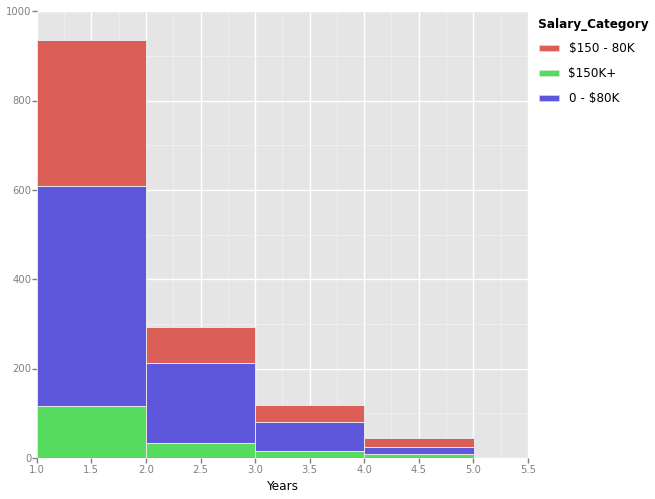

<ggplot: (293626629)>

In [274]:
from pprint import pprint
import numpy as np

grouped = df.groupby(['Cleaned_Name'])
sal_cat = grouped.apply(lambda x: (len(x), x.Salary_Category.values[-1]))


years, category = zip(*sal_cat.values.tolist())
numyr = pd.DataFrame.from_items([('Years', years), ('Salary_Category', category)])
ggplot(numyr, aes('Years', fill='Salary_Category')) + geom_histogram(binwidth=1)


In [309]:
groups = numyr.groupby('Years')

#print groups['Salary_Category'].value_counts()
groups.count().iloc[0]

for group in groups:
    print group[1]['Salary_Category'].value_counts()/float(len(group[1]))

numyr['Salary_Category'].value_counts()/float(len(numyr))

0 - $80k      0.524013
$150 - 80k    0.351121
$150k+        0.124867
dtype: float64
0 - $80k      0.614334
$150 - 80k    0.273038
$150k+        0.112628
dtype: float64
0 - $80k      0.559322
$150 - 80k    0.313559
$150k+        0.127119
dtype: float64
0 - $80k      0.413793
$150 - 80k    0.344828
$150k+        0.241379
dtype: float64
$150 - 80k    0.666667
0 - $80k      0.266667
$150k+        0.066667
dtype: float64


0 - $80k      0.540948
$150 - 80k    0.334770
$150k+        0.124282
dtype: float64

### If you start off at the bottom, where do you end up?

In [112]:
df = df_orig
df.loc[ df.Gender =='?', 'Gender'] = np.nan
df.loc[ df.Salary ==0, 'Gender'] = np.nan
df = df.dropna()

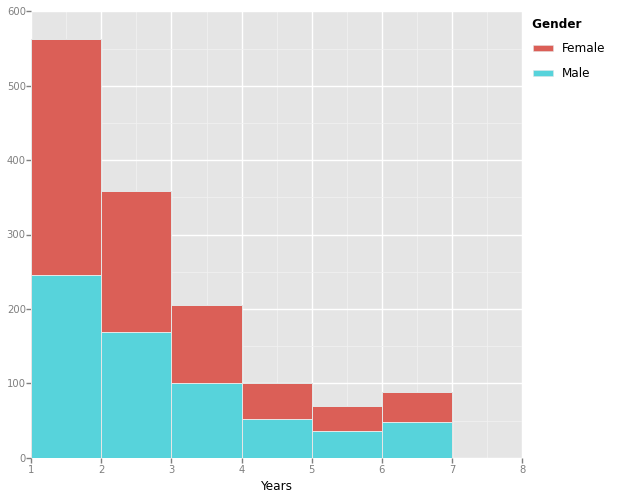

<ggplot: (282533381)>

In [113]:
from pprint import pprint
import numpy as np

grouped = df.groupby(['Cleaned_Name'])
num_years = grouped.apply(lambda x: (len(x), x.Gender.values[0]))

years, gender = zip(*num_years.values.tolist())
numyr = pd.DataFrame.from_items([('Years', years), ('Gender', gender)])
ggplot(numyr, aes('Years', fill='Gender')) + geom_histogram(binwidth=1)


#salary, gender = zip(*jumps.values.tolist())
#jump_list = zip(jumps.index.values.tolist(), salary, gender)
#sorted(jump_list, key=lambda x: x[1], reverse=True)

#dfj = pd.DataFrame.from_items([('Salary', salary), ('Gender', gender)])


#ggplot(dfj, aes('Salary')) +\
#    geom_histogram(dfj[ dfj['Gender']=='female'], fill = "red", alpha = 0.2, binwidth=10000) +\
#    geom_histogram(dfj[ dfj['Gender']=='male'], fill = "blue", alpha = 0.2, binwidth=10000)


women are less likely to stay on

In [14]:
grouped = numyr.groupby("Years")
for group in grouped:
    print group[1].Gender.value_counts()/float(len(group[1]))

numyr.Gender.value_counts()/len(numyr)

NameError: name 'numyr' is not defined

### What are the salary rate increases for those who start off with <$60k and are present for 3+ years

female    124
male      113
dtype: int64


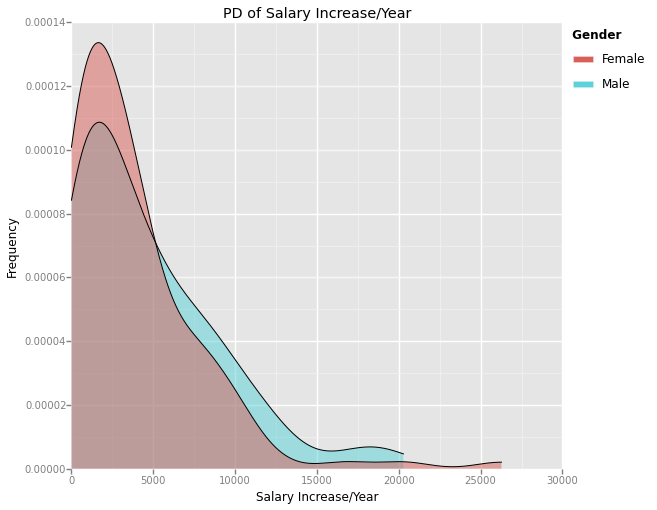

<ggplot: (282228241)>

In [32]:
from pprint import pprint
import numpy as np


dfx = df_orig
dfx.loc[ dfx.Gender =='?', 'Gender'] = np.nan
dfx.loc[ dfx.Salary ==0, 'Gender'] = np.nan
dfx = dfx.dropna()

grouped = dfx.groupby(['Cleaned_Name'])
grouped = grouped.filter(lambda x: np.min(x.Salary)<60000).groupby(['Cleaned_Name'])
grouped = grouped.filter(lambda x: len(x) > 2).sort(['Cleaned_Name','Year']).groupby(['Cleaned_Name'])

MF = grouped.apply(lambda x: x.Gender.values[0])
print MF.value_counts()

delta = grouped.apply(lambda x: ( (max(x.Salary) - min(x.Salary))/float(len(x)), x.Gender.values[0]))

rate, gender = zip(*delta.values.tolist())
df_rate = pd.DataFrame.from_items([('Rate', rate), ('Gender', gender)])
ggplot(df_rate, aes('Rate', fill='Gender')) + geom_density(alpha=0.5) + \
xlab("Salary Increase/Year") + ylab('Frequency') + ggtitle("PD of Salary Increase/Year")

In [29]:
out, bins = pd.cut(df_rate['Rate'], range(-1,30000,5000), labels=range(1,7), retbins=True)
df_rate['Bin'] = out


merged = df_rate.groupby(['Gender','Bin']).Rate.agg([len])
female = map(round, np.divide([91,25,5,1,1,1], float(124)) * 100)
male = map(round, np.divide([70,29,10,3,1,0], float(113)) * 100)
print female
print male

[73.0, 20.0, 4.0, 1.0, 1.0, 1.0]
[62.0, 26.0, 9.0, 3.0, 1.0, 0.0]


15


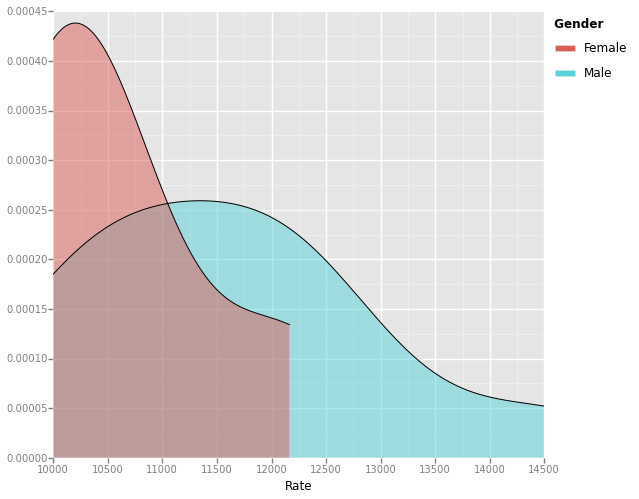

<ggplot: (292021369)>

In [82]:
low_inc = df_rate[ (df_rate['Rate']<15000) & (df_rate['Rate']>=10000) ]
print len(low_inc)
ggplot(low_inc, aes('Rate',fill='Gender')) + geom_density(alpha=0.5)
#ggplot(low_inc, aes('Rate',fill='Gender')) + geom_histogram(alpha=0.5)

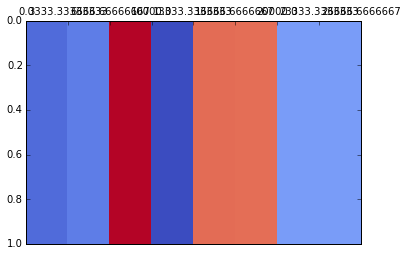

In [243]:
from pprint import pprint
bins = np.linspace(0, 30000, 10)
df_rate['Bin'] = np.digitize(df_rate.Rate,bins)
grouped = df_rate.groupby('Bin')

total = len(df_rate)
p = df_rate.Gender.value_counts()['male']/float(total)

zscore = []
for group in grouped:
    try:
        x = group[-1].Gender.value_counts()['male']
    except:
        x = 0
    n = len(group[-1])
    zscore.append( (x - n*p) / (n*p*(1-p))**0.5 )

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#column_labels = list('A')
#row_labels = list('WXYZ')
zscore = np.array(zscore)


fig, ax = plt.subplots()
#fig(num=None, figsize=(8, 6))
heatmap = ax.pcolor(zscore[np.newaxis, :], cmap=plt.cm.coolwarm_r)
ax.set_xticklabels(bins)
ax.xaxis.tick_top()
ax.invert_yaxis()

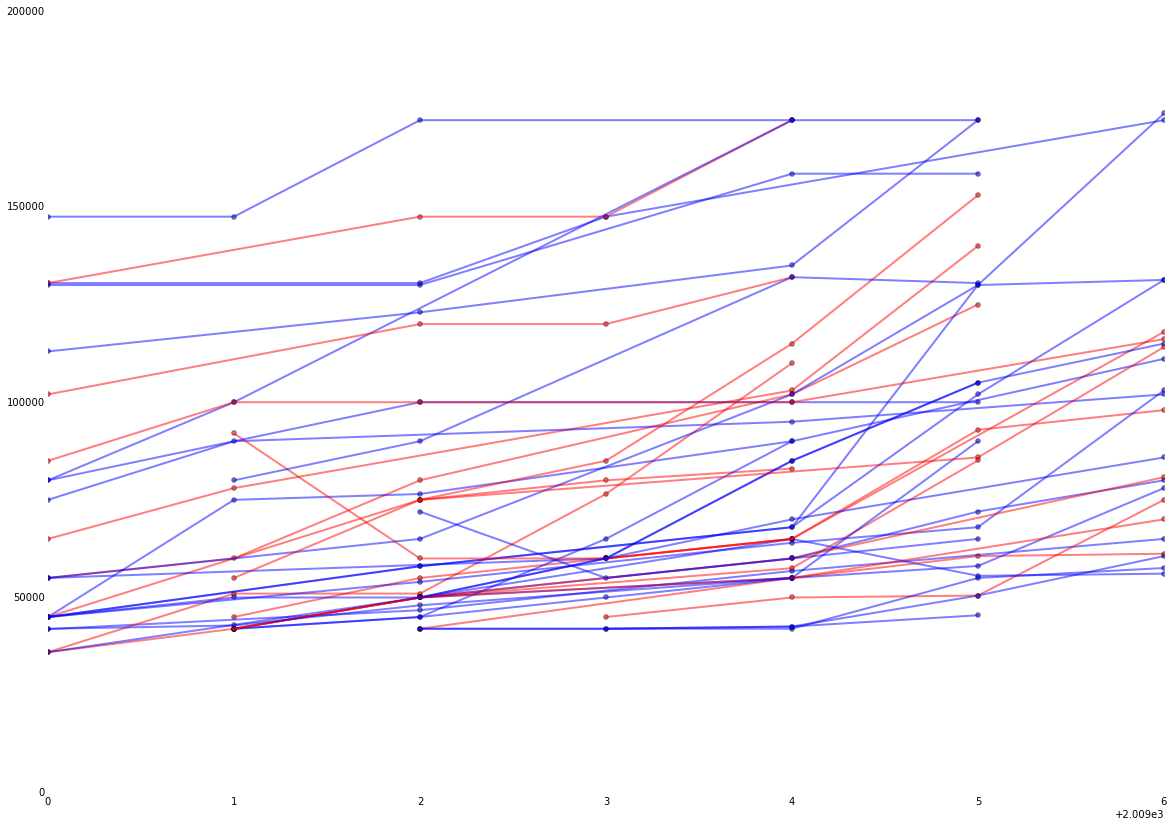

In [487]:
import matplotlib.pyplot as plt


grouped = df.groupby(['Cleaned_Name'])
grouped = grouped.filter(lambda x: len(x) > 3).sort(['Cleaned_Name','Year'])
grouped = grouped.groupby(['Cleaned_Name'])


plt.figure(figsize=(20, 14))    
ax = plt.subplot(111)    
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)    

ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()    
  
# Limit the range of the plot to only where the data is.    
# Avoid unnecessary whitespace.    
plt.ylim(0, 200000)    
plt.xlim(2009, 2015)   

# Remove the tick marks; they are unnecessary with the tick lines we just plotted.    
plt.tick_params(axis="both", which="both", bottom="off", top="off",    
                labelbottom="on", left="off", right="off", labelleft="on")  
  
# Make sure your axis ticks are large enough to be easily read.    
# You don't want your viewers squinting to read your plot.    
#plt.yticks(range(0, 91, 10), [str(x) + "%" for x in range(0, 91, 10)], fontsize=14)    
#plt.xticks(fontsize=14)    

import itertools
for name, item in grouped:
    if item.iloc[0].Gender == 'female':
        col = 'r'
    else:
        col = 'b'    
    plt.plot(item.Year, item.Salary, col, alpha=0.5, linewidth=2.0)
    plt.scatter(item.Year, item.Salary,c=col, alpha=0.5)
  

    
    
    
    
#    plt.plot(item.x, item.value, 'b', alpha=0.5)
#    
#plt.show()

In [122]:
grouped = df.groupby(['Cleaned_Name'])
grouped = grouped.filter(lambda x: len(x) > 3).sort(['Cleaned_Name','Year'])
#grouped = grouped.groupby(['Cleaned_Name'])

{'amanda anderson': [8, 494, 961, 1419, 1878],
 'amy brundage': [49, 533, 1454, 1921],
 'brian deese': [103, 1042, 2408, 2888],
 'brian deguzman': [104, 1044, 1496, 2799],
 'brian mosteller': [318, 779, 1698, 2890],
 'chase cushman': [94, 1035, 1492, 1951, 2897],
 'danielle gray': [173, 1095, 2471, 1549],
 'david simas': [409, 876, 1796, 2257],
 'deesha dyer': [596, 1058, 2425, 1510, 2916],
 'denis mcdonough': [300, 763, 1213, 1671],
 'elizabeth nelson': [329, 1238, 2618, 1705],
 'emmett beliveau': [27, 980, 1435, 1891],
 'fiona reeves': [374, 833, 1286, 2669, 1751],
 'gregory lorjuste': [282, 1194, 1650, 2115, 3177],
 'harrison ford': [619, 1074, 1529, 1987, 2824],
 'howli ledbetter': [258, 717, 1176, 1630, 2095],
 'irene hsu': [1120, 1580, 2044, 2826],
 'jason smith': [882, 1339, 2717, 1801],
 'jeffrey stephens': [422, 888, 1350, 1806, 2940],
 'jeffrey tiller': [1366, 1825, 2287, 2829],
 'john payne': [1262, 2644, 1725, 2183],
 'jonathan asen': [498, 965, 2336, 1422, 1880],
 'jordan 

In [128]:
df['Cleaned_Title'].value_counts()

staff assistant                                                                                             100
analyst                                                                                                      70
senior policy advisor                                                                                        54
special assistant to the president and associate counsel to the president                                    41
deputy associate counsel for presidential personnel                                                          37
policy advisor                                                                                               32
senior analyst                                                                                               29
policy assistant                                                                                             26
information services operator                                                                           

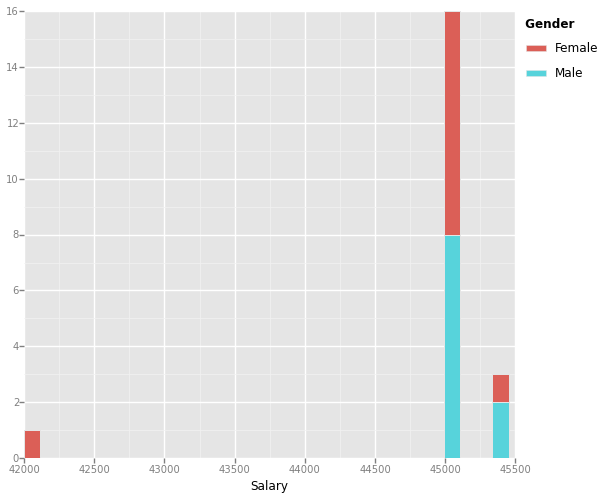

<ggplot: (297884741)>

In [378]:
ggplot(df[ df['Cleaned_Title']=='coordinator'], aes('Salary', fill='Gender')) +\
geom_histogram()

In [366]:
df[ df['Cleaned_Title'] == 'analyst'].Gender.value_counts()

male      39
female    31
dtype: int64

In [114]:
df[ df['Salary'] < 80000].Cleaned_Title.value_counts()

AttributeError: 'DataFrame' object has no attribute 'Cleaned_Title'

## Is it a pipeline?

#### If you start off entry level @ <$60k and have 4 years, what are the results?

In [183]:
import itertools
df = df_orig
df.loc[ df.Gender =='?', 'Gender'] = np.nan
df.loc[ df.Salary ==0, 'Gender'] = np.nan
df = df.dropna()

In [203]:
grouped = df.groupby(df['Cleaned_Name'])
grouped = grouped.filter( lambda x: (np.min(x['Salary'])<60000) ).groupby(df['Cleaned_Name'])

data = {}
for year in range(2009, 2016):    
    print year

    #select those that started in year
    subgroup = grouped.filter( lambda x: np.min(x['Year'])==year ).groupby(df['Cleaned_Name'])
    
    data[year] = []
    for person in subgroup:
        subdf = person[1]
        maxyr = max( [yr for yr in subdf['Year'] if yr <= year+4] )
        data[year].append([ subdf[subdf['Year']==maxyr].Salary.values[0], person[0], maxyr-year+1, subdf['Gender'].values[0] ])




2009
2010
2011
2012
2013
2014
2015


In [219]:
master_data = []
for year in range(2009, 2013):
    master_data.extend(data[year])

temp = zip(*master_data)
tempdf = pd.DataFrame(master_data, columns=['Salary', 'Cleaned_Name', 'Years', 'Gender'])
tempdf.Gender.value_counts()

female    242
male      198
dtype: int64

#### Highest Salary Obtained in 4 years

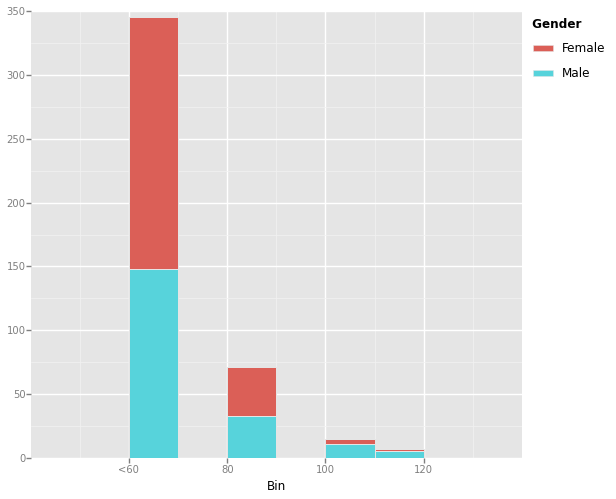

<ggplot: (288975573)>

In [266]:
import matplotlib.pyplot as plt

out, bins = pd.cut(tempdf['Salary'], [0, 60000, 80000, 100000, 120000], labels=[1,2,3,4], retbins=True)
tempdf['Bin'] = out

ggplot(tempdf, aes('Bin',fill='Gender')) + geom_histogram(binwidth=0.5) + scale_x_continuous(limits = (0,5), breaks = range(1,5), labels=['<60','80','100','120'])


#### Given that men and women start off <$60, men are more likely to obtain a higher salary within 4 years.

In [285]:
merged = tempdf.groupby(['Bin', 'Gender']).Salary.agg([len])
female = np.divide([198, 38, 4, 2], float(242))
male = np.divide([148, 33, 11, 5], float(198))

print female
print male
#ggplot(tempdf, aes('Bin', fill='Gender')) + geom_density(alpha=0.5)

1-float(198+148)/len(tempdf)

[ 0.81818182  0.15702479  0.01652893  0.00826446]
[ 0.74747475  0.16666667  0.05555556  0.02525253]


0.21363636363636362

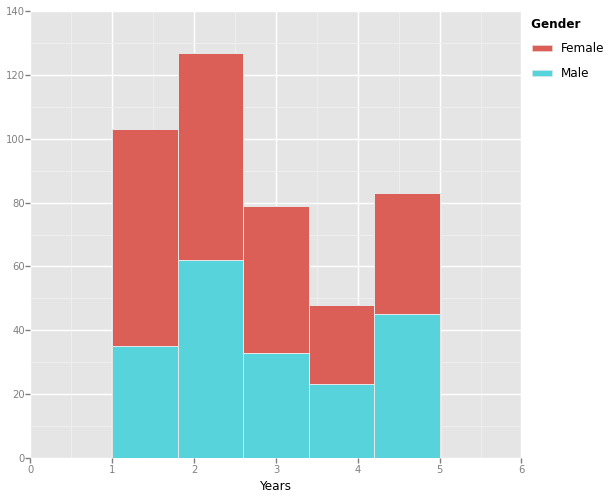

<ggplot: (289080093)>

In [267]:
ggplot(tempdf, aes('Years',fill='Gender')) + geom_histogram(binwidth=0.8)

[ 0.28099174  0.26859504  0.19008264  0.10330579  0.15702479]
[ 0.17676768  0.31313131  0.16666667  0.11616162  0.22727273]


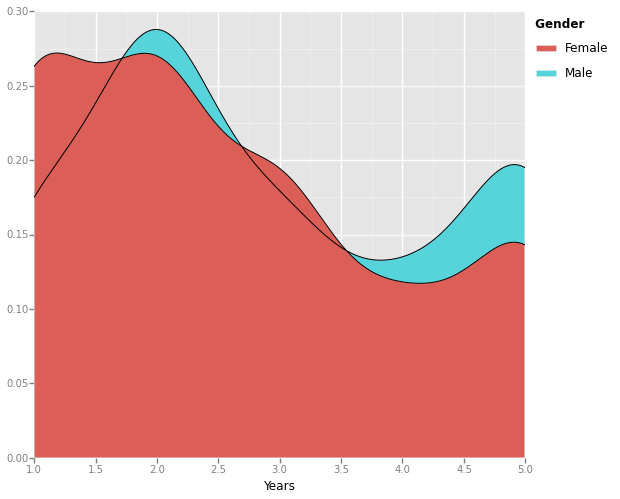

<ggplot: (290248529)>

In [282]:
#men 198
#women 242

merged = tempdf.groupby(['Years', 'Gender']).Salary.agg([len])
female = np.divide([68, 65, 46, 25, 38], float(242))
male = np.divide([35, 62, 33, 23, 45], float(198))

print female
print male

ggplot(tempdf, aes('Years', fill='Gender')) + geom_density()

In [277]:
print tempdf.Years.value_counts()
print len(tempdf)
print float(48)/440

2    127
1    103
5     83
3     79
4     48
dtype: int64
440
0.109090909091


In [ ]:
gender, max_salary, years = zip(*max_data.values.tolist())
df_maxsalary = pd.DataFrame.from_items([('Max_Salary', max_salary), ('Gender', gender), ('Years', years)])
ggplot(df_maxsalary, aes('Years', 'Max_Salary', color='Gender')) + geom_jitter()
out, bins = pd.cut(df_maxsalary['Max_Salary'], [0, 60000, 80000, 100000, 200000], labels=None, retbins=True)
df_maxsalary['Bin'] = out

#df_maxsalary['Bin']
ggplot(df_maxsalary, aes('Bin', fill='Gender')) + geom_histogram()

In [120]:
#import statsmodels.formula.api as sm
#result = sm.ols(formula="Max_Salary ~ Years", data=df_maxsalary).fit()
#print result.summary()

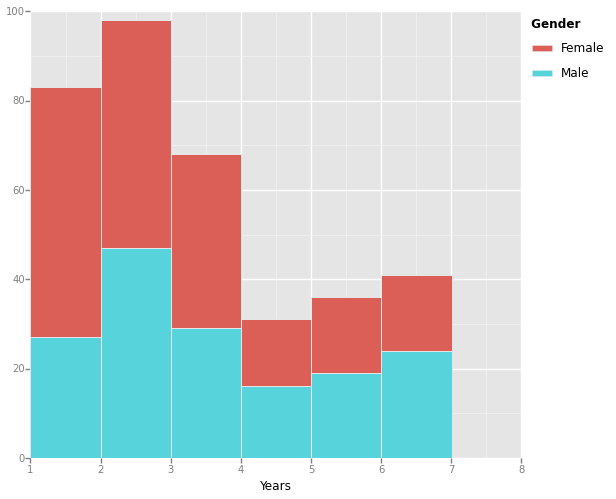

<ggplot: (281872993)>

In [76]:
ggplot(df_maxsalary, aes('Years', fill='Gender')) + geom_histogram(binwidth=1)

## Is the skewed M/F ratio <$80k a recent thing?

2009
2010
2011
2012
2013
2014
2015


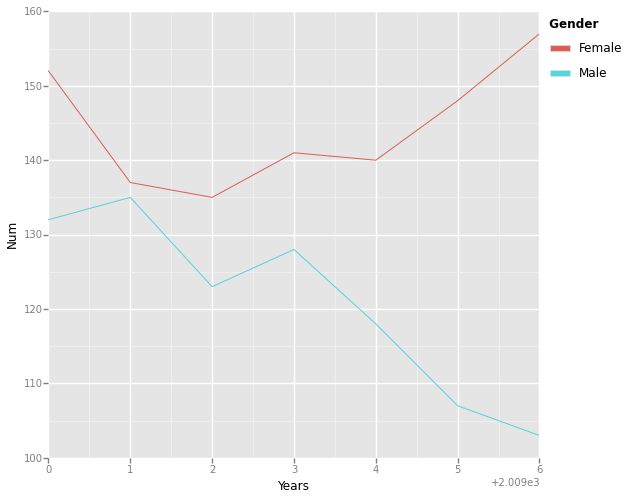

<ggplot: (281299045)>

In [58]:
# Find sex distribution of those with salaries < $80k
# on a year by year basis.

MFdata = []
for year in range(2009, 2016):
    print year
    MF = df[ (df['Year']==year) & (df['Salary']<80000) ].Gender.value_counts()
    MFdata.append(MF.values)

dfF = pd.DataFrame.from_items( [ ('Num', map(lambda x: x[0], MFdata)), ('Gender', ['female']*7), ('Years', range(2009,2016))])
dfM = pd.DataFrame.from_items( [ ('Num', map(lambda x: x[1], MFdata)), ('Gender', ['male']*7), ('Years', range(2009,2016))])
dfcohort = pd.concat([dfF, dfM])

ggplot(dfcohort, aes('Years', 'Num', color='Gender')) + geom_line()

## Where is the influx coming from?  What do the new employees look like

In [67]:
df = df_orig
df.loc[ df.Gender=='?', 'Gender' ] = np.nan
df.loc[ df.Salary==0, 'Gender' ] = np.nan
df = df.dropna()

grouped = df.groupby(df['Cleaned_Name'])
grouped = grouped.filter( lambda x: ( min(x['Salary'])<80000 ) ).groupby( df['Cleaned_Name'] )
MFdata2 = []


#Find sex distribution of new employees per year.
#New employee means that min(Years) == current year

for year in range(2009, 2016):
    # Did they first start in year XXXX?
    grouped2 = grouped.filter( lambda x: year == np.min(x.Year.values) ).groupby( df['Cleaned_Name'] )
    print year, len(grouped2.groups)
    MF = grouped2.apply(lambda x: x.Gender.values[0])
    MFdata2.append(MF.values)

#MFdata - np array of 'male', 'female'

2009 284
2010 71
2011 107
2012 105
2013 56
2014 93
2015 100


### What is the gender distribution of new employees?  

#### Since 2010, new employees <$80k, that have never worked in the white house, have been skewing heavily female.  3:2 ratio.

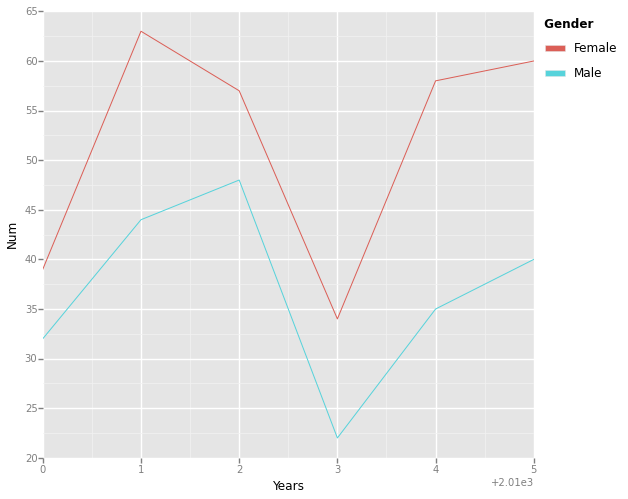

<ggplot: (278314433)>

In [68]:
#What is the gender distribution of new employees?

from collections import Counter

counted = map(Counter, MFdata2)
male = map(lambda x: x['male'], counted[1:])
female = map(lambda x: x['female'], counted[1:])


dfF = pd.DataFrame.from_items( [ ('Num', female), ('Gender', ['female']*len(female)), ('Years', range(2010,2016))])
dfM = pd.DataFrame.from_items( [ ('Num', male), ('Gender', ['male']*len(male)), ('Years', range(2010,2016))])
dfcohort = pd.concat([dfF, dfM])

ggplot(dfcohort, aes('Years', 'Num', color='Gender')) + geom_line()

#### What is the gender distribution of returning employees?

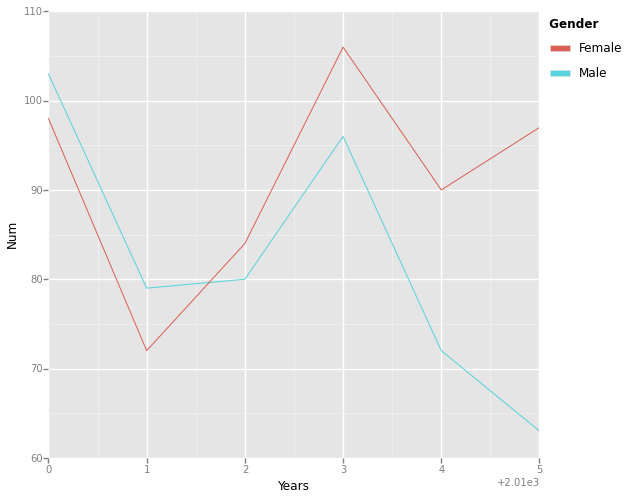

<ggplot: (279088149)>

In [66]:
#What is the gender distribution of returning employees?

new_m = np.array(male)
new_f = np.array(female)

male2 = map( lambda x: x[1], MFdata )
female2 = map( lambda x: x[0], MFdata )

male2 = np.array(male2[1:])
female2 = np.array(female2[1:])
male3 = np.subtract(male2, new_m)
female3 = np.subtract(female2, new_f)


dfF = pd.DataFrame.from_items( [ ('Num', female3), ('Gender', ['female']*len(female3)), ('Years', range(2010,2016))])
dfM = pd.DataFrame.from_items( [ ('Num', male3), ('Gender', ['male']*len(male3)), ('Years', range(2010,2016))])
dfcohort = pd.concat([dfF, dfM])

ggplot(dfcohort, aes('Years', 'Num', color='Gender')) + geom_line()

In [ ]:
g = ggplot(...)
fig = g.draw()
#or
g.draw() # or print(g)
fig = plt.gcf() 
ax = plt.gca()
